In [1]:
import json
import ufl
import dolfin as dl

#sys.path.append(os.environ.get('HIPPYLIB_PATH', "../../"))
import hippylib as hp
#sys.path.append(os.environ.get('HIPPYFLOW_PATH',"../../"))
import hippyflow as hf

from helpers import *
from generate_samples import *
from train_nn import *



/Users/deepprakashravi/miniforge3/envs/gempy_dino/lib/python3.10/site-packages/dolfin/jit/jit.py:121: RuntimeWarning: mpi4py.MPI.Session size changed, may indicate binary incompatibility. Expected 32 from C header, got 40 from PyObject
  def compile_class(cpp_data, mpi_comm=MPI.comm_world):
/Users/deepprakashravi/miniforge3/envs/gempy_dino/lib/python3.10/site-packages/dolfin/jit/jit.py:46: RuntimeWarning: mpi4py.MPI.Session size changed, may indicate binary incompatibility. Expected 32 from C header, got 40 from PyObject
  if MPI.size(mpi_comm) == 1:


Setting Backend To: AvailableBackends.numpy


/Users/deepprakashravi/miniforge3/envs/gempy_dino/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
nx =31; ny = 31
nodes = (nx+1)*(ny+1)
mesh = dl.RectangleMesh(dl.Point(0.0, 0.0), dl.Point(1.0, 1.0), nx, ny)
Vh_STATE = dl.FunctionSpace(mesh, "CG", 2)
Vh_PARAMETER = dl.FunctionSpace(mesh, "CG", 1)
Vh = [Vh_STATE, Vh_PARAMETER, Vh_STATE]

d2v = dl.dof_to_vertex_map(Vh[hp.PARAMETER])
v2d = dl.vertex_to_dof_map(Vh[hp.PARAMETER])


def u_boundary(x, on_boundary):
    return on_boundary and ( x[1] < dl.DOLFIN_EPS or x[1] > 1.0 - dl.DOLFIN_EPS)

u_bdr = dl.Expression("x[1]", degree=1)
u_bdr0 = dl.Constant(0.0)
bc = dl.DirichletBC(Vh[hp.STATE], u_bdr, u_boundary)
bc0 = dl.DirichletBC(Vh[hp.STATE], u_bdr0, u_boundary)

f = dl.Constant(0.0)
#f = dl.Expression("sin(2*pi*x[0]) * exp(x[1]+ x[0])", degree=5)

def pde_varf(u,m,p):
    return m*ufl.inner(ufl.grad(u), ufl.grad(p))*ufl.dx - f*p*ufl.dx
    

pde = hp.PDEVariationalProblem(Vh, pde_varf, bc, bc0, is_fwd_linear=True)


In [3]:
Borehole_location = [0.1, 0.5, 0.9]
Borehole_extent = [0.4, 0.7, 0.4]
Borehole_points = [50, 50, 50]
target_list=[]
for i, x in enumerate(Borehole_location):
    z_data = np.linspace(Borehole_extent[i], 1, Borehole_points[i])
    first_column = np.full((z_data.shape[0],), x)
    two_d_array = np.column_stack((first_column, z_data))
    target_list.append(two_d_array)
targets = np.vstack(target_list)
# targets = Vh[hp.STATE].tabulate_dof_coordinates()
#targets

In [4]:
B = hp.assemblePointwiseObservation(Vh[hp.STATE], targets)

In [5]:
# Compute singular values only
singular_values = np.linalg.svd(B.array(), compute_uv=False)

print("Singular values:", singular_values)

Singular values: [1.66434523e+00 1.65276213e+00 1.63321419e+00 1.60664258e+00
 1.57304554e+00 1.53500046e+00 1.48773711e+00 1.44417149e+00
 1.39237307e+00 1.33841397e+00 1.28515735e+00 1.22395976e+00
 1.18130275e+00 1.12270841e+00 1.07234286e+00 1.02739347e+00
 1.01756707e+00 1.01748722e+00 1.01715380e+00 1.01697992e+00
 1.01671227e+00 1.01658106e+00 1.01571157e+00 1.01487840e+00
 1.01486325e+00 1.01471054e+00 1.01288385e+00 1.01267818e+00
 1.01180489e+00 1.01160981e+00 1.00825292e+00 1.00791116e+00
 1.00667252e+00 1.00622138e+00 1.00480606e+00 1.00432782e+00
 1.00068621e+00 1.00029422e+00 9.99925611e-01 9.98972628e-01
 9.86690025e-01 9.83743275e-01 9.83730789e-01 9.83633069e-01
 9.83505666e-01 9.82671532e-01 9.82551644e-01 9.82277932e-01
 9.82197274e-01 9.81692822e-01 9.81538139e-01 9.78929213e-01
 9.78618214e-01 9.77475738e-01 9.67652104e-01 9.58623464e-01
 9.40516261e-01 8.37031555e-01 8.35175250e-01 8.34193717e-01
 8.32699246e-01 8.20945700e-01 8.19549188e-01 8.18869308e-01
 8.1465

In [6]:
u_trial = dl.TrialFunction(Vh[hp.STATE])
u_test = dl.TestFunction(Vh[hp.STATE])

M_U = dl.assemble(dl.inner(u_trial,u_test)*dl.dx)

I_U = hf.StateSpaceIdentityOperator(M_U)
#observable = hf.LinearStateObservable(pde,M_U)
observable_1 = hf.LinearStateObservable(pde,I_U)
observable_2 = hf.LinearStateObservable(pde,B)

Jm_1 = hf.ObservableJacobian(observable_1)
Jm_2 = hf.ObservableJacobian(observable_2)

m_trial = dl.TrialFunction(Vh[hp.PARAMETER])
m_test = dl.TestFunction(Vh[hp.PARAMETER])

M_M = dl.assemble(dl.inner(m_trial,m_test)*dl.dx)

Setting Backend To: AvailableBackends.numpy


/Users/deepprakashravi/miniforge3/envs/gempy_dino/lib/python3.10/site-packages/gempy/core/data/geo_model.py:164: UserWarning: You are using refinement and passing a regular grid. The resolution of the regular grid will be overwritten
  warnings.warn(
/Users/deepprakashravi/miniforge3/envs/gempy_dino/lib/python3.10/site-packages/gempy_viewer/API/_plot_2d_API.py:172: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  p.fig.show()


Active grids: ['custom']
Setting Backend To: AvailableBackends.numpy
Setting Backend To: AvailableBackends.numpy


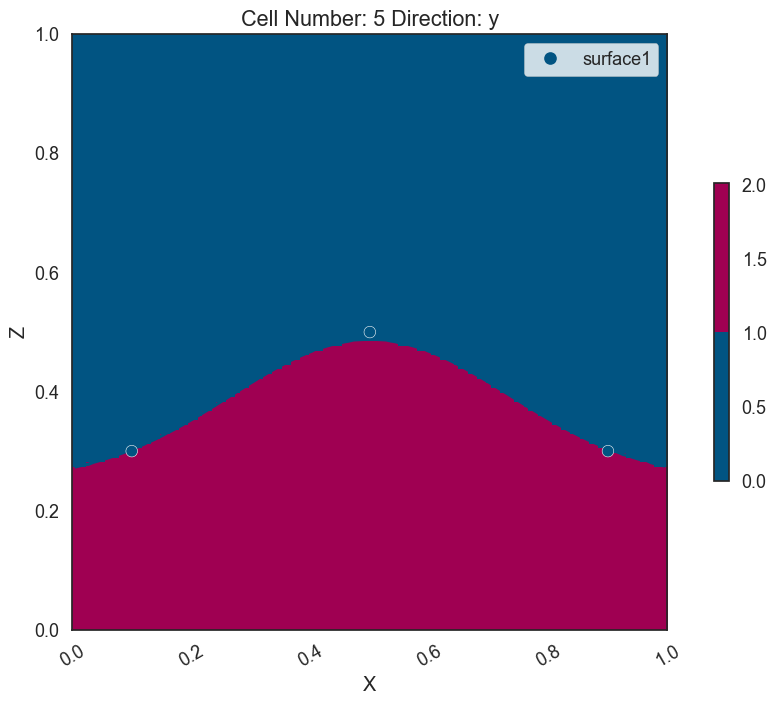

In [7]:
m_initial, sp_coords_copy_test, gempy_model= create_true_data(mesh=mesh, nodes=nodes, filename=None)

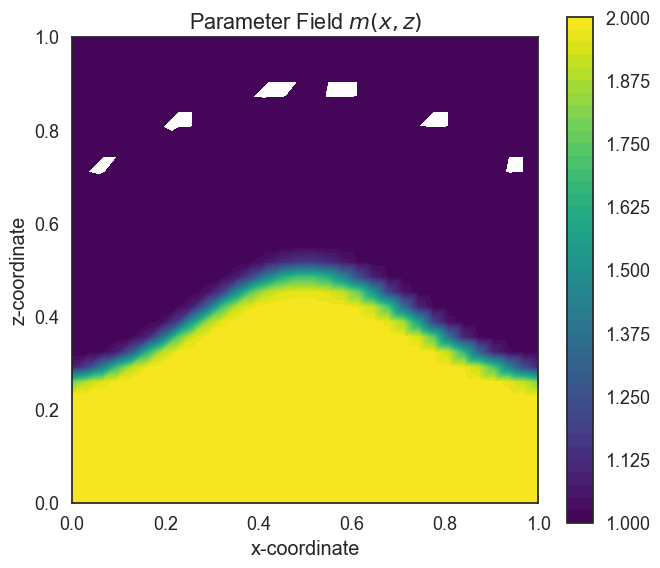

In [8]:
m = dl.Function(Vh[hp.PARAMETER])
m.vector().set_local(m_initial[d2v])
# plt.axis("off")
col = dl.plot(m,cmap="viridis" )
fig = plt.gcf()
fig.colorbar(col) 
# Add axis labels and title
plt.xlabel("x-coordinate")
plt.ylabel("z-coordinate")
plt.title("Parameter Field $m(x,z)$")

plt.tight_layout()
fig.set_size_inches(6, 6)

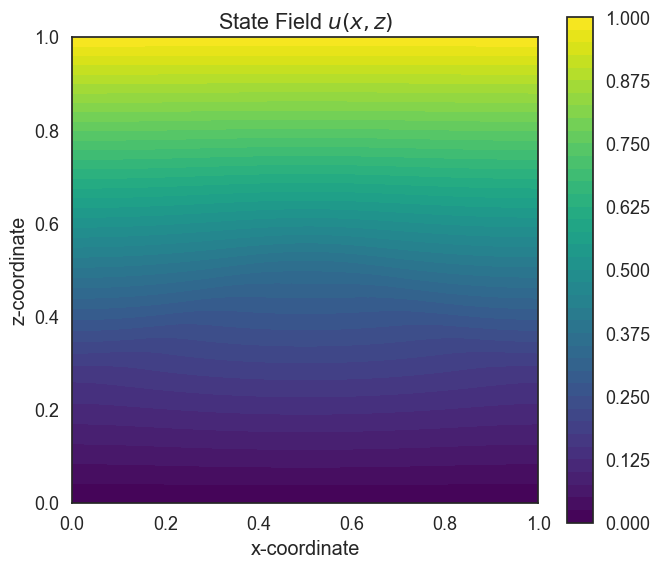

In [9]:
u = dl.Function(Vh[hp.STATE])
uadj = dl.Function(Vh[hp.ADJOINT])
x = [u.vector(),m.vector(),uadj.vector()]
pde.solveFwd(x[hp.STATE], x)
# Get the data
u_true = x[hp.STATE].get_local()
# plot u_true
u.vector().set_local(u_true)
# plt.axis("off")
col = dl.plot(u,cmap="viridis" )
fig = plt.gcf()
fig.colorbar(col) 
# Add axis labels and title
plt.xlabel("x-coordinate")
plt.ylabel("z-coordinate")
plt.title("State Field $u(x,z)$")

plt.tight_layout()
fig.set_size_inches(6, 6)


In [ ]:
nsamples = c.shape[0]

m = dl.Function(Vh[hp.PARAMETER])

u = dl.Function(Vh[hp.STATE])
uadj = dl.Function(Vh[hp.ADJOINT])

dU = u.vector().get_local().shape[0]

dC = c.shape[1]
dO = targets.shape[0]
# once you have modified the means of c->m(c) comment this
uhat = dl.Function(Vh[hp.STATE])
m_nodes_hat = dl.Function(Vh[hp.PARAMETER])
m_hat = dl.Function(Vh[hp.PARAMETER])
u_data = np.zeros((nsamples,dU))
u_obs  = np.zeros((nsamples, dO))
J_data = np.zeros((nsamples, dU, dC))
Jm_obs = np.zeros((nsamples, dO, dC))
plotting = False
for sample_index in range(nsamples):
    # Do something here to modify the coefficients
   
    m_values = m_data[sample_index,:]
    m.vector().set_local(m_values[d2v]) #uncomment this
    # m.vector().set_local(m_values[d2v] +0.1*np.random.randn(m_values.shape[0])) #comment this
    if plotting:
        #plt.axis("off")
        dl.plot(m,cmap="viridis")
        fig = plt.gcf()
        fig.set_size_inches(1, 1)
        plt.show()
        # Plot with color

    
    x = [u.vector(),m.vector(),uadj.vector()]
    pde.solveFwd(x[hp.STATE], x)
    
    Jm_1.observable.setLinearizationPoint(x)
    Jm_2.observable.setLinearizationPoint(x)
    
    # Get the data
    u_data[sample_index,:] = x[hp.STATE].get_local()
    u_obs[sample_index,:] = observable_2.evalu(x[hp.STATE]).get_local()
    # Calculate the Jacobian
    Jhelp = dl.Vector()
    for component in range(dC):
        m_nodes_hat.vector().set_local(dmdc_data[sample_index,:,component][d2v]) 
        Jm_1.mult(m_nodes_hat.vector(),uhat.vector()) 
        # Multiply dmdc by Mass matrix.
        # M_M.mult(m_nodes_hat.vector(), m_hat.vector()) 
        # Jm.mult(m_hat.vector(),uhat.vector()) 
        J_data[sample_index,:,component] = uhat.vector().get_local()
        Jm_2.mult(m_nodes_hat.vector(), Jhelp) 
        Jm_obs[sample_index, :,component]= Jhelp.get_local()
        
    
    
u_data.shape, J_data.shape, u_obs.shape, Jm_obs.shape

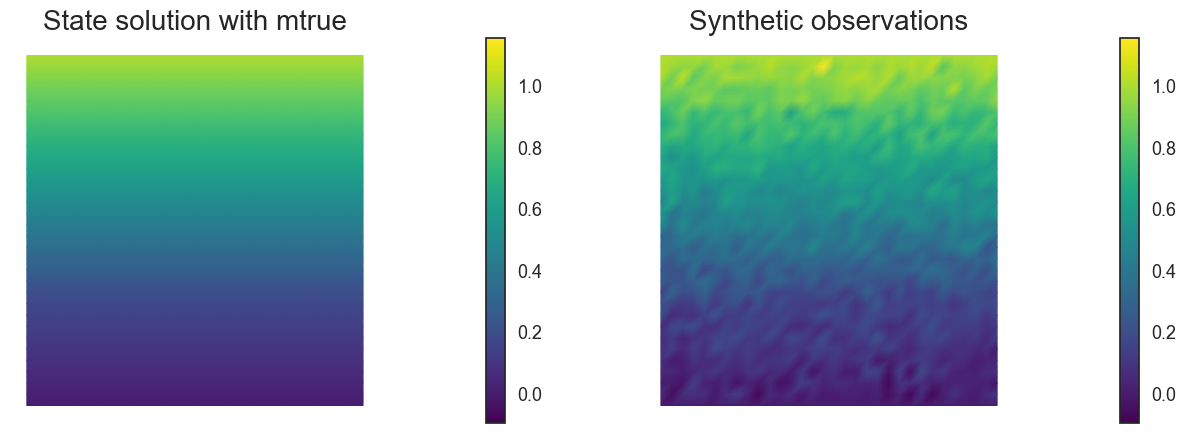

In [28]:
# noise level
noise_level = 0.05


ud = dl.Function(Vh[hp.STATE])
ud.assign(u)

# perturb state solution and create synthetic measurements ud
# ud = u + ||u||/SNR * random.normal
MAX = ud.vector().norm("linf")

# Create noise vector and insert the numpy array
noise = dl.Vector()
M_U.init_vector(noise, 1)
hp.parRandom.normal(noise_level * MAX, noise)

bc0.apply(noise)

ud.vector().axpy(1., noise)

# plot
hp.nb.multi1_plot([u, ud], ["State solution with mtrue", "Synthetic observations"])
# Add axis labels and title

plt.show()


In [61]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype =torch.float32
Mph= torch.tensor(np.load('./saved_model/Mphi.npy'), dtype=dtype, device=device)
phi = torch.tensor(np.load('./saved_model/phi.npy'), dtype=dtype, device=device)
u_shift = torch.tensor(np.load('./saved_model/u_shift.npy'), dtype=dtype, device=device)


In [62]:
# Load the full model directly
model_without_jacobian = torch.load("./saved_model/model_without_jacobian.pth",weights_only=False)
model_jacobian_full    = torch.load("./saved_model/model_jacobian_full.pth", weights_only=False)
model_jacobian_truncated    = torch.load("./saved_model/model_jacobian_truncated.pth", weights_only=False)


In [63]:
def pyro_model(interpolation_input_ ,num_layers, NN_model, u_shift, phi, obs_data, device ):
        
            """
            This Pyro model represents the probabilistic aspects of the geological model.
            It defines a prior distribution for the top layer's location and
            computes the thickness of the geological layer as an observed variable.

            
            interpolation_input_: represents the dictionary of random variables for surface parameters
            
            num_layers: represents the number of layers we want to include in the model
            
            """

            
            parameter = []
            
            # Create a random variable based on the provided dictionary used to modify input data of gempy
            counter=1
            for interpolation_input_data in interpolation_input_[:num_layers]:
                
                # Check if user wants to create random variable based on modifying the surface points of gempy
                if interpolation_input_data["update"]=="interface_data":
                    # Check what kind of distribution is needed
                    if interpolation_input_data["prior_distribution"]=="normal":
                        mean = interpolation_input_data["normal"]["mean"]
                        std  = interpolation_input_data["normal"]["std"]
                        parameter.append(pyro.sample("mu_"+ str(counter), dist.Normal(mean, std)))
                        
                    elif interpolation_input_data["prior_distribution"]=="uniform":
                        min = interpolation_input_data["uniform"]["min"]
                        max = interpolation_input_data["uniform"]["min"]
                        parameter.append(pyro.sample("mu_"+ str(interpolation_input_data['id']), dist.Uniform(min, max)))

                        
                    else:
                        print("We have to include the distribution")
                
                counter=counter+1
                
            input_data = torch.tensor(parameter, device=device)
            NN_model.eval()
            NN_output = NN_model(input_data)
            output =torch.matmul(NN_output, phi.T) + u_shift
            #print(output.shape)
            #output = NN_output
            
            with pyro.plate("likelihood", obs_data.shape[0]):
                pyro.sample("obs", dist.Normal(output, 0.05), obs=obs_data)
            
            

In [64]:
###############################################################################
# Make a list of gempy parameter which would be treated as a random variable
###############################################################################

test_list=[]
std = 0.03
test_list.append({"update":"interface_data","id":torch.tensor([1]), "direction":"Z", "prior_distribution":"normal","normal":{"mean":torch.tensor(sp_coords_copy_test[1,2],dtype=dtype), "std":torch.tensor(std,dtype=dtype)}})
test_list.append({"update":"interface_data","id":torch.tensor([2]), "direction":"Z", "prior_distribution":"normal","normal":{"mean":torch.tensor(sp_coords_copy_test[2,2],dtype=dtype), "std":torch.tensor(std,dtype=dtype)}})
test_list.append({"update":"interface_data","id":torch.tensor([3]), "direction":"Z", "prior_distribution":"normal","normal":{"mean":torch.tensor(sp_coords_copy_test[3,2],dtype=dtype), "std":torch.tensor(std,dtype=dtype)}})
test_list.append({"update":"interface_data","id":torch.tensor([6]), "direction":"Z", "prior_distribution":"normal","normal":{"mean":torch.tensor(sp_coords_copy_test[6,2],dtype=dtype), "std":torch.tensor(std,dtype=dtype)}})
test_list.append({"update":"interface_data","id":torch.tensor([7]), "direction":"Z", "prior_distribution":"normal","normal":{"mean":torch.tensor(sp_coords_copy_test[7,2],dtype=dtype), "std":torch.tensor(std,dtype=dtype)}})
test_list.append({"update":"interface_data","id":torch.tensor([8]), "direction":"Z", "prior_distribution":"normal","normal":{"mean":torch.tensor(sp_coords_copy_test[8,2],dtype=dtype), "std":torch.tensor(std,dtype=dtype)}})
test_list.append({"update":"interface_data","id":torch.tensor([11]), "direction":"Z", "prior_distribution":"normal","normal":{"mean":torch.tensor(sp_coords_copy_test[11,2],dtype=dtype), "std":torch.tensor(std,dtype=dtype)}})
test_list.append({"update":"interface_data","id":torch.tensor([12]), "direction":"Z", "prior_distribution":"normal","normal":{"mean":torch.tensor(sp_coords_copy_test[12,2],dtype=dtype), "std":torch.tensor(std,dtype=dtype)}})
test_list.append({"update":"interface_data","id":torch.tensor([13]), "direction":"Z", "prior_distribution":"normal","normal":{"mean":torch.tensor(sp_coords_copy_test[13,2],dtype=dtype), "std":torch.tensor(std,dtype=dtype)}})
num_layers = len(test_list) 


In [65]:
model = model_jacobian_full

In [66]:
obs_data = torch.tensor(ud.vector().get_local(), dtype=dtype, device=device)
#print(obs_data.shape)
dot = pyro.render_model(pyro_model, model_args=(test_list, num_layers, model,  u_shift, phi, obs_data , device),render_distributions=True)

/Users/deepprakashravi/miniforge3/envs/gempy_dino/lib/python3.10/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


array([[<Axes: title={'center': 'mu_1'}>,
        <Axes: title={'center': 'mu_1'}>],
       [<Axes: title={'center': 'mu_2'}>,
        <Axes: title={'center': 'mu_2'}>],
       [<Axes: title={'center': 'mu_3'}>,
        <Axes: title={'center': 'mu_3'}>],
       [<Axes: title={'center': 'mu_4'}>,
        <Axes: title={'center': 'mu_4'}>],
       [<Axes: title={'center': 'mu_5'}>,
        <Axes: title={'center': 'mu_5'}>],
       [<Axes: title={'center': 'mu_6'}>,
        <Axes: title={'center': 'mu_6'}>],
       [<Axes: title={'center': 'mu_7'}>,
        <Axes: title={'center': 'mu_7'}>],
       [<Axes: title={'center': 'mu_8'}>,
        <Axes: title={'center': 'mu_8'}>],
       [<Axes: title={'center': 'mu_9'}>,
        <Axes: title={'center': 'mu_9'}>],
       [<Axes: title={'center': 'obs'}>, <Axes: title={'center': 'obs'}>]],
      dtype=object)

<Figure size 800x1000 with 0 Axes>

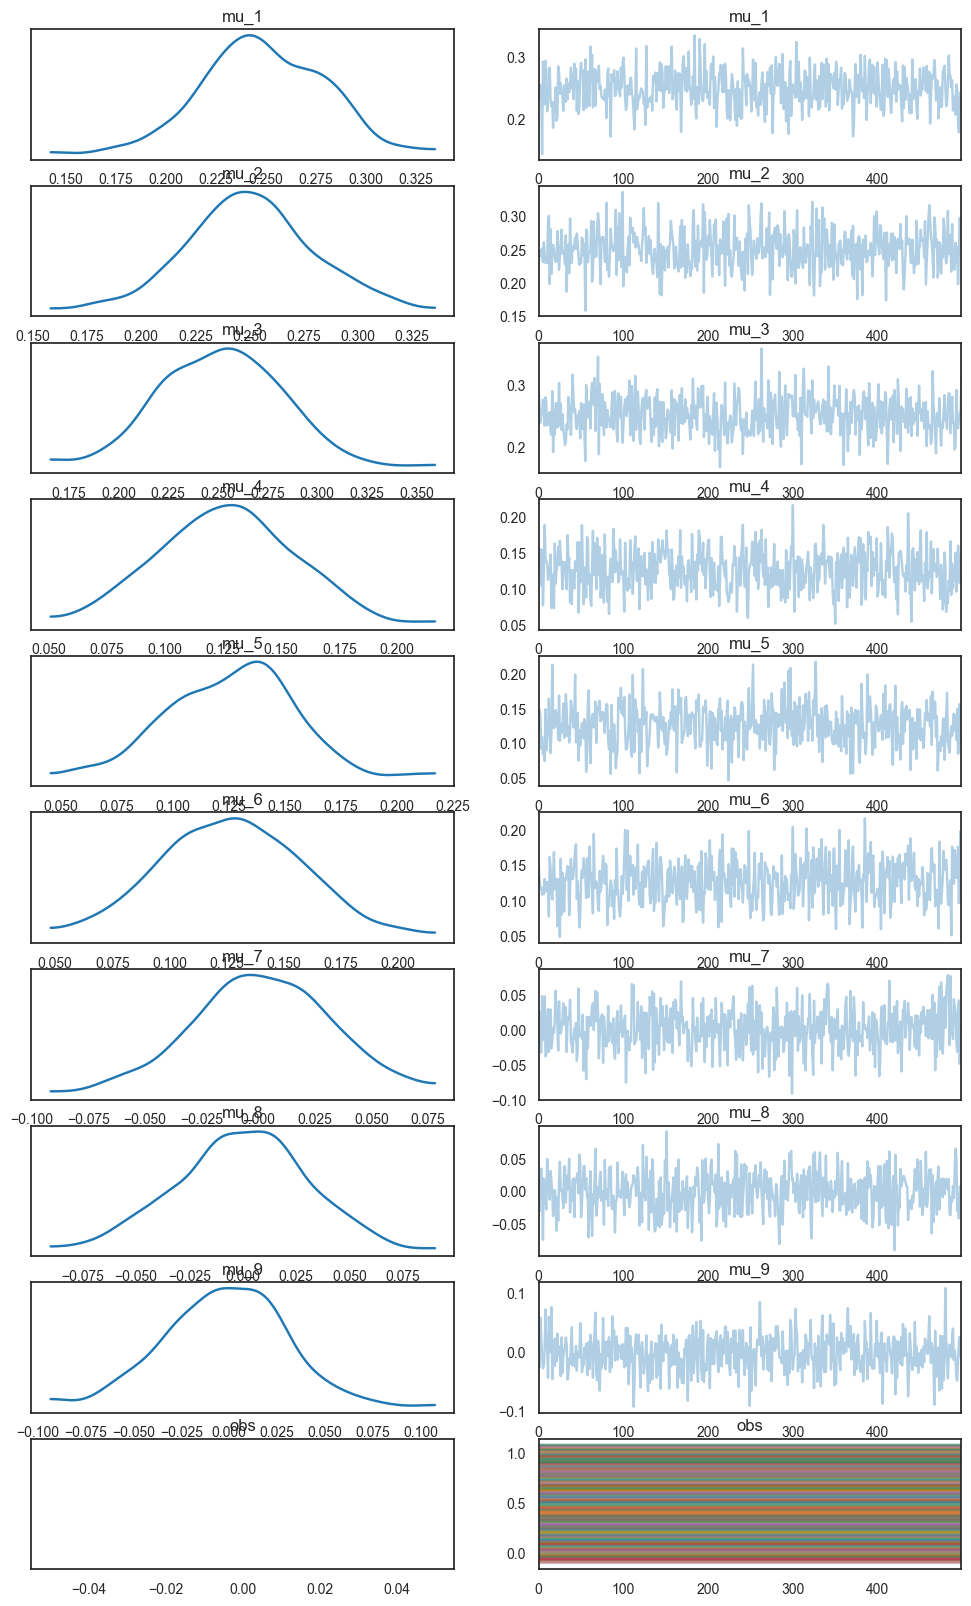

In [67]:
pyro.set_rng_seed(42)
import arviz as az
from pyro.infer import MCMC, NUTS, Predictive, EmpiricalMarginal
from pyro.infer.autoguide import init_to_mean, init_to_median, init_to_value
prior = Predictive(pyro_model,num_samples=500)(test_list, num_layers, model,  u_shift, phi, obs_data , device)
plt.figure(figsize=(8,10))
data = az.from_pyro(prior=prior)
az.plot_trace(data.prior)

In [68]:
################################################################################
# Posterior
################################################################################
pyro.primitives.enable_validation(is_validate=True)
nuts_kernel = NUTS(pyro_model, step_size=0.0085, adapt_step_size=True, target_accept_prob=0.9, max_tree_depth=10, init_strategy=init_to_mean)
mcmc = MCMC(nuts_kernel, num_samples=1000,warmup_steps=1000, mp_context="spawn", num_chains=1, disable_validation=True)
mcmc.run(test_list, num_layers, model, u_shift, phi, obs_data , device)
posterior_samples = mcmc.get_samples(group_by_chain=False)

Sample: 100%|██████████| 2000/2000 [53:22,  1.60s/it, step size=8.64e-06, acc. prob=0.885]


/Users/deepprakashravi/miniforge3/envs/gempy_dino/lib/python3.10/site-packages/arviz/data/io_pyro.py:158: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


<Figure size 800x1000 with 0 Axes>

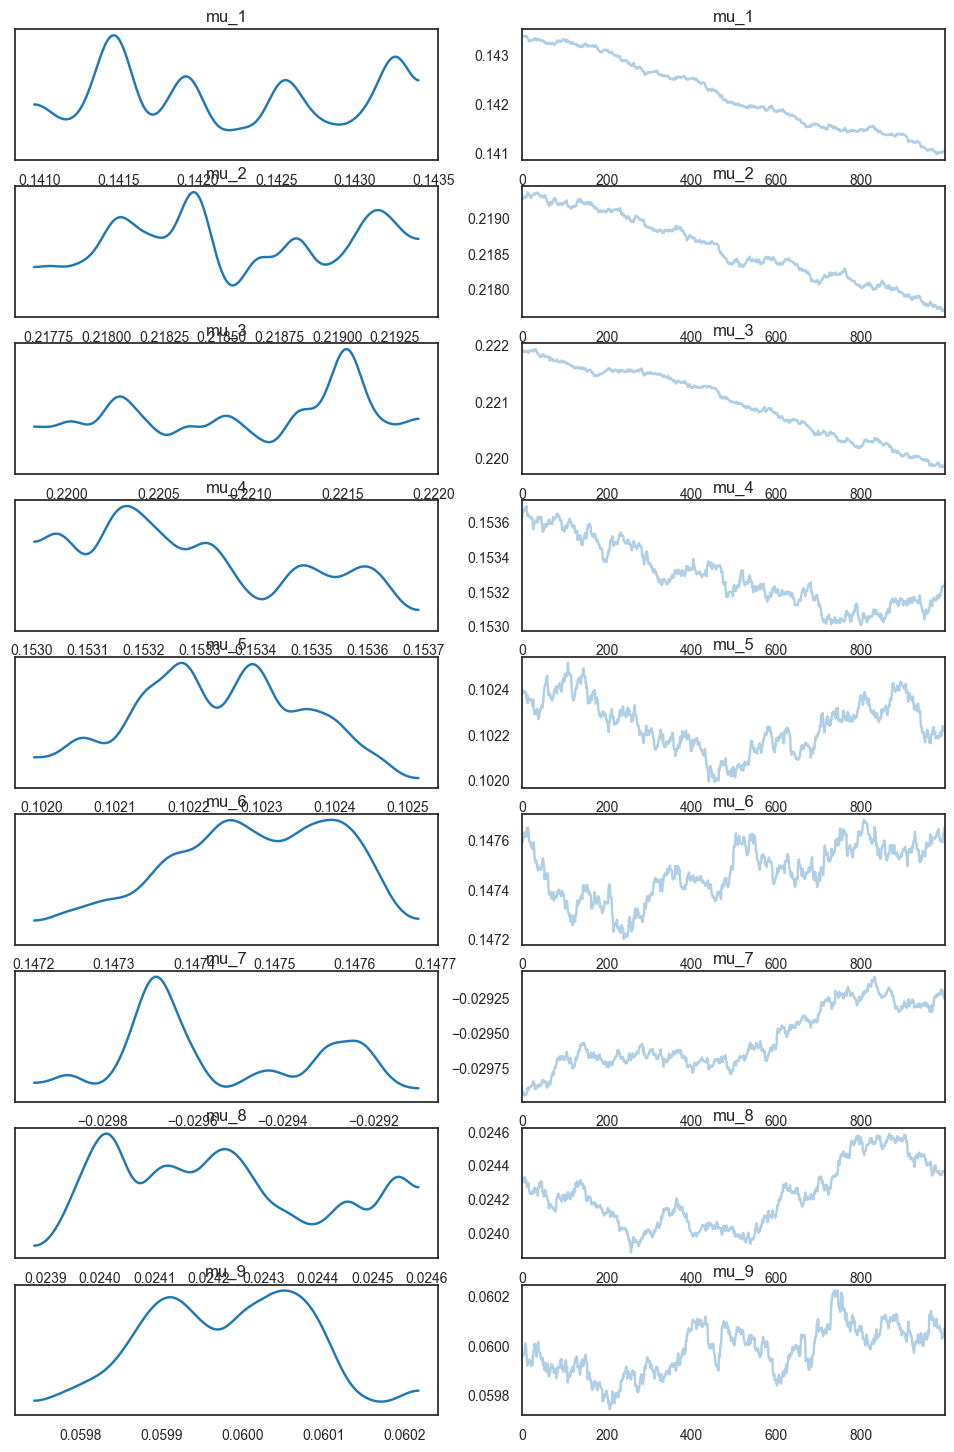

<Figure size 800x1000 with 0 Axes>

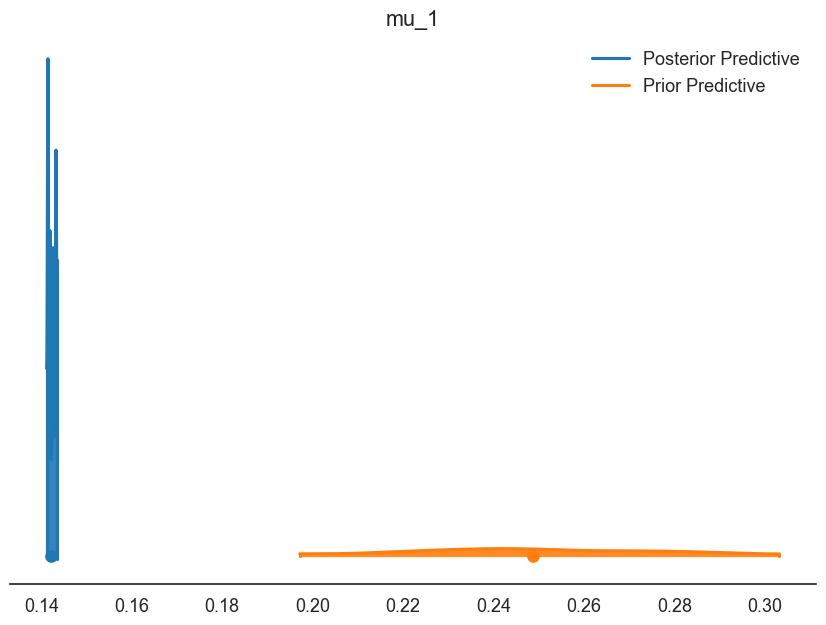

<Figure size 800x1000 with 0 Axes>

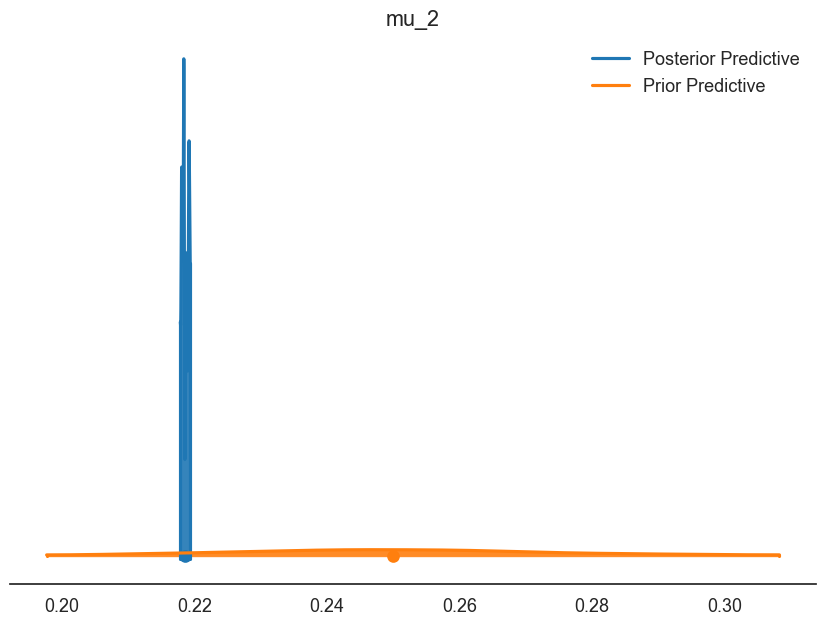

<Figure size 800x1000 with 0 Axes>

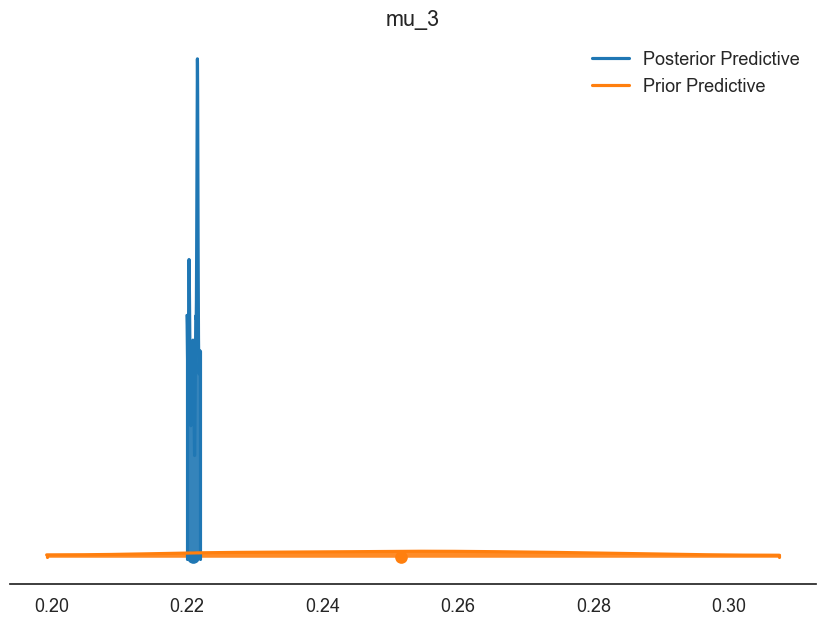

<Figure size 800x1000 with 0 Axes>

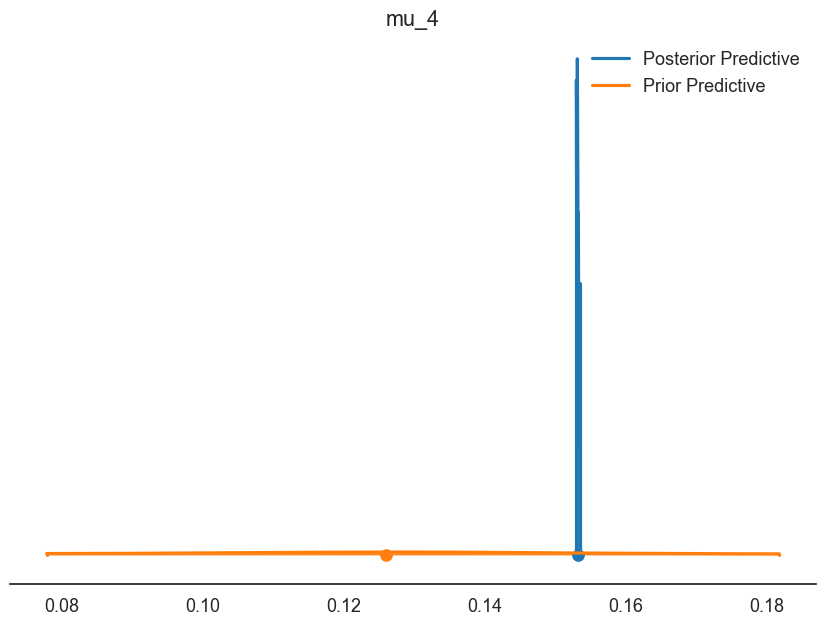

<Figure size 800x1000 with 0 Axes>

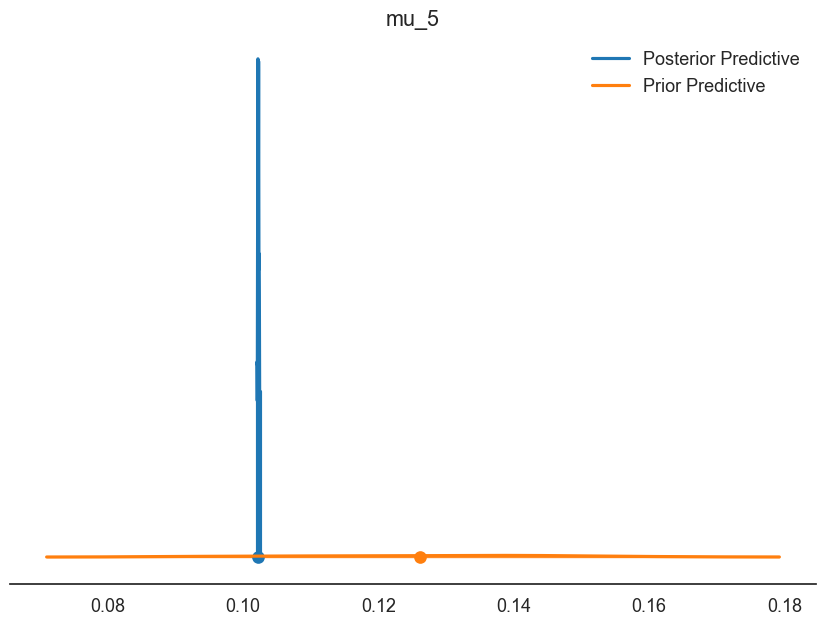

<Figure size 800x1000 with 0 Axes>

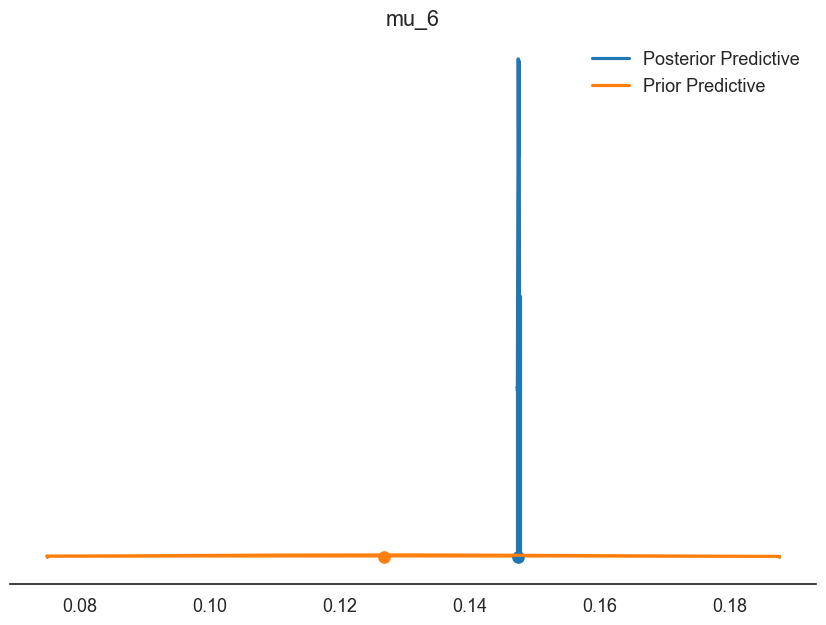

<Figure size 800x1000 with 0 Axes>

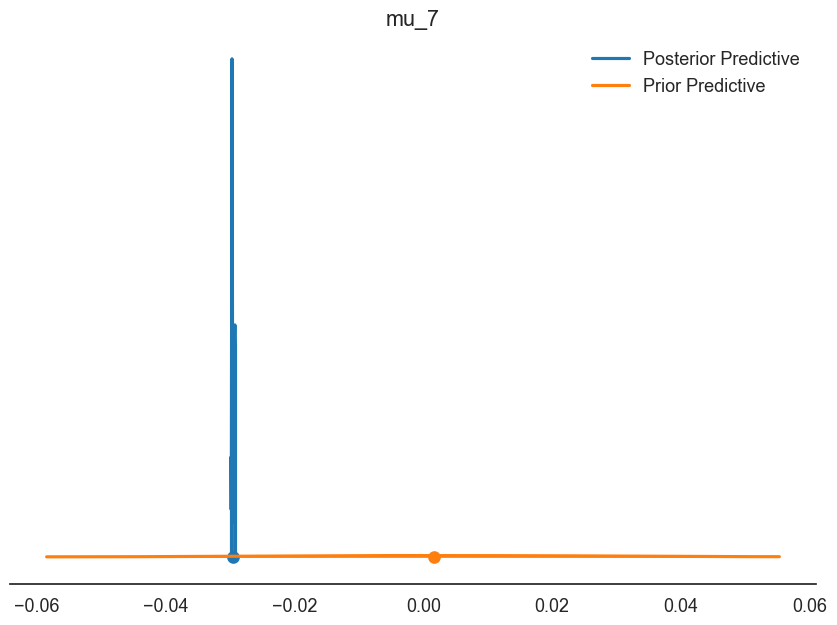

<Figure size 800x1000 with 0 Axes>

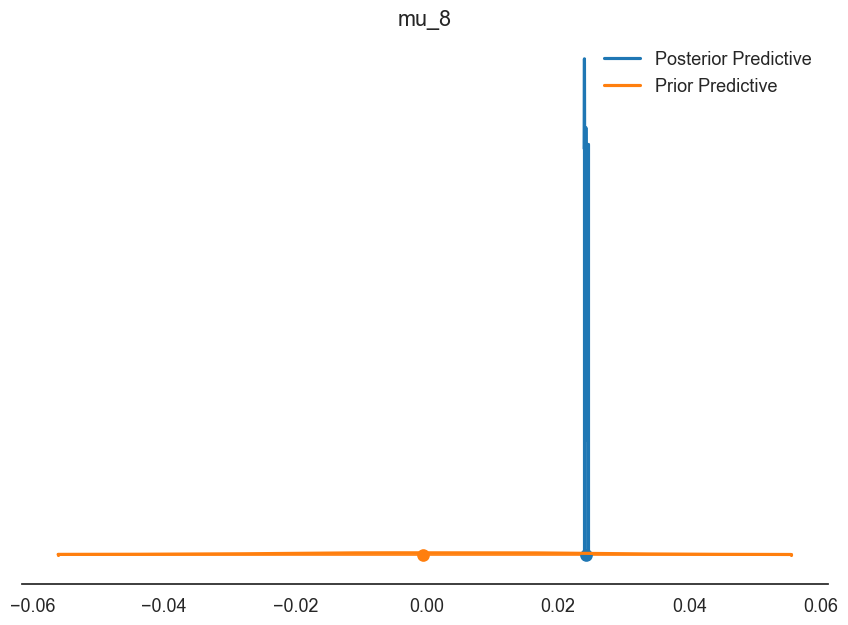

<Figure size 800x1000 with 0 Axes>

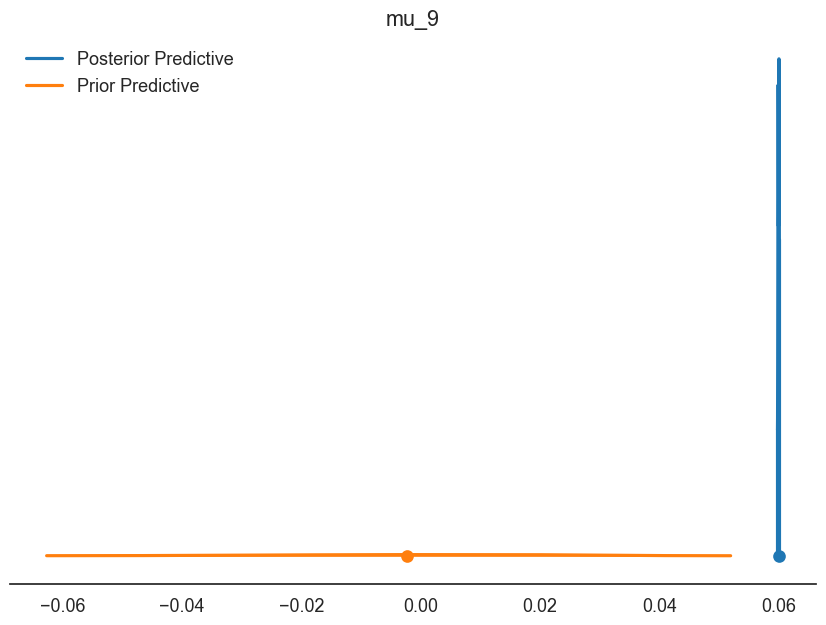

In [69]:
posterior_predictive = Predictive(pyro_model, posterior_samples)(test_list, num_layers, model,  u_shift, phi, obs_data , device)
plt.figure(figsize=(8,10))
data = az.from_pyro(posterior=mcmc, prior=prior, posterior_predictive=posterior_predictive)
az.plot_trace(data)
###############################################TODO################################
# Plot and save the file for each parameter
###################################################################################
for i in range(len(test_list)):
    plt.figure(figsize=(8,10))
    az.plot_density(
    data=[data.posterior, data.prior],
    shade=.9,
    var_names=['mu_' +str(i+1)],
    data_labels=["Posterior Predictive", "Prior Predictive"],
    )


In [70]:
list_parameter = []
for index, (key, values) in enumerate(posterior_samples.items()):
    print("Prior mean: ", test_list[index]["normal"]["mean"], "Prior std: ", test_list[index]["normal"]["std"])
    print("Posterior mean: ",torch.mean(values), "Posterior std: ",torch.std(values))
    list_parameter.append(torch.mean(values).to(torch.float64))

Prior mean:  tensor(0.2500) Prior std:  tensor(0.0300)
Posterior mean:  tensor(0.1422) Posterior std:  tensor(0.0007)
Prior mean:  tensor(0.2500) Prior std:  tensor(0.0300)
Posterior mean:  tensor(0.2185) Posterior std:  tensor(0.0005)
Prior mean:  tensor(0.2500) Prior std:  tensor(0.0300)
Posterior mean:  tensor(0.2209) Posterior std:  tensor(0.0006)
Prior mean:  tensor(0.1250) Prior std:  tensor(0.0300)
Posterior mean:  tensor(0.1533) Posterior std:  tensor(0.0002)
Prior mean:  tensor(0.1250) Prior std:  tensor(0.0300)
Posterior mean:  tensor(0.1022) Posterior std:  tensor(0.0001)
Prior mean:  tensor(0.1250) Prior std:  tensor(0.0300)
Posterior mean:  tensor(0.1475) Posterior std:  tensor(0.0001)
Prior mean:  tensor(0.) Prior std:  tensor(0.0300)
Posterior mean:  tensor(-0.0295) Posterior std:  tensor(0.0002)
Prior mean:  tensor(0.) Prior std:  tensor(0.0300)
Posterior mean:  tensor(0.0242) Posterior std:  tensor(0.0002)
Prior mean:  tensor(0.) Prior std:  tensor(0.0300)
Posterior me

Setting Backend To: AvailableBackends.PYTORCH
Setting Backend To: AvailableBackends.numpy


/Users/deepprakashravi/miniforge3/envs/gempy_dino/lib/python3.10/site-packages/gempy/core/data/geo_model.py:164: UserWarning: You are using refinement and passing a regular grid. The resolution of the regular grid will be overwritten
  warnings.warn(
/Users/deepprakashravi/miniforge3/envs/gempy_dino/lib/python3.10/site-packages/gempy_viewer/API/_plot_2d_API.py:172: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  p.fig.show()


Setting Backend To: AvailableBackends.numpy
Setting Backend To: AvailableBackends.numpy


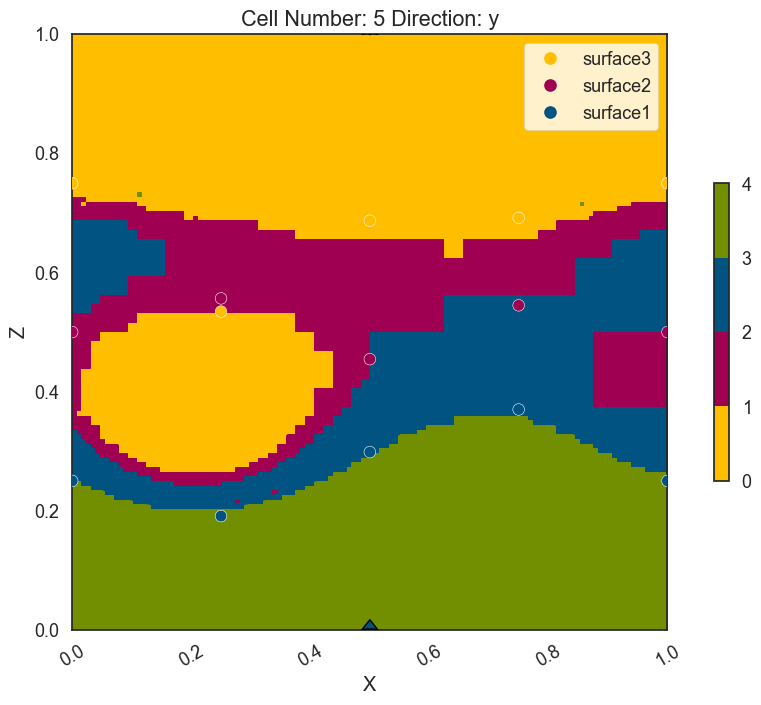

In [71]:
generate_final_model(geo_model=gempy_model, interpolation_input_=test_list, num_layers=num_layers,posterior_data=list_parameter)